# Stockes Flow

Durant ce travail, nous essairons de résoudre l'équation biharmonique 
\begin{equation}
\nabla^4 \psi= 0
\end{equation}
Celle-ci est déduite des équatoins de Navier-Stokes pour de fluides incompréssibles et pour un nombre de Reynolds proche de 0. La démonstration étant donnée dans l'énoncé, nous ne la redémontrons pas. Notre problème est de résoudre cette équation dans une "boite" avec les conditions aux bords suivantes : 

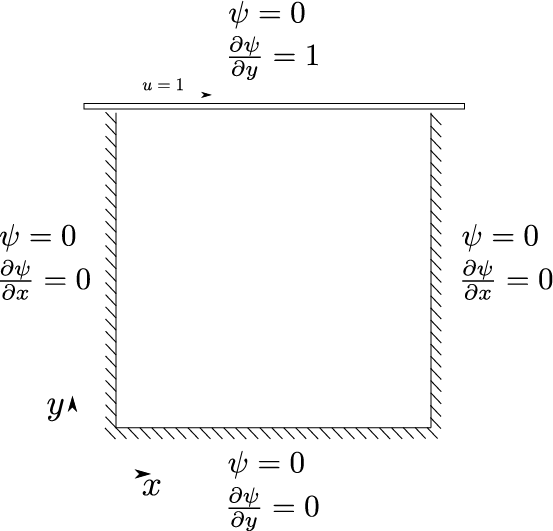

In [3]:
from IPython.display import Image
Image(filename='drivencavity.png')

La première question est la suivante, pouvons nous justifier ces conditions aux bords ? A parler avec lucas


Ensuite, nous devons trouver une différence centrale finie discrète d'ordre 2 pour l'équation biharmonique. Nous avons, en dévellopant le double Laplacien, l'équation suivante :

\begin{equation}
\nabla^4 \psi= \frac{\partial^4 \psi}{\partial x^4}+\frac{\partial^4 \psi}{\partial y^4}+2\frac{\partial^4 \psi}{\partial x^2 \partial y^2}
\end{equation}

De discrétiser ceci nous a donner plus de difficulters que prévus, nous avons alors préférer un différente approche pour résoudre ce problème. Voyons le Laplacien comme un opérateur étant appliqué 2 fois sur notre fonction. En discrétisant l'opérateur, on trouve alors comme expression :

\begin{equation}
\nabla^2 \nabla^2 \psi = \frac{\nabla^2\psi_{i-1,j}+\nabla^2\psi_{i+1,j}-2\nabla^2\psi_{i,j}}{\Delta x^2}+\frac{\nabla^2\psi_{i,j-1}\nabla^2\psi_{i,j+1}-2\nabla^2\psi_{i,j}}{\Delta y^2}
\end{equation}

En prenant pour des écarts égaux $\Delta x=\Delta y$:

\begin{equation}
\nabla^2 \nabla^2 \psi = \frac{\nabla^2\psi_{i-1,j}+\nabla^2\psi_{i+1,j}+\nabla^2\psi_{i,j-1}\nabla^2\psi_{i,j+1}-4\nabla^2\psi_{i,j}}{\Delta x^2}
\end{equation}

On a ainsi discrétisé le premier Laplacien, il faut ensuite faire de même pour le second. On trouve au final par le même procédé l'équation suivante : 

\begin{equation}
\nabla^4 \psi = \frac{\psi_{i-2,j}-8\psi_{i-1,j}+20\psi_{i,j}-8\psi_{i+1,j}+\psi_{i+2,j}+\psi_{i,j-2}-8\psi_{i,j-1}-8\psi_{i,j+1}+\psi_{i,j+2}}{\Delta x^2}
\end{equation}

Codons tout ceci (je sais moche mais je changerai), et importons déjà nos librairie python.

In [1]:
import numpy

from matplotlib import pyplot
from matplotlib import rcParams

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from math import pi



rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16


In [4]:
def A(psi):
    psic=psi.copy()
    psicc=psi.copy()
    psicc[2:-2,2:-2]=(psic[:-4,2:-2]+psic[2:-2,:-4]+psic[2:-2,4:]-8*psic[1:-3,2:-2]+20*psic[2:-2,2:-2]-8*psic[3:-1,2:-2]+psic[4:,2:-2]-8*psic[2:-2,3:-1]-8*psic[2:-2,1:-3]+2*psic[3:-1,1:-3]+2*psic[3:-1,3:-1]+2*psic[1:-3,1:-3]+2*psic[1:-3,3:-1])
    return psicc

Avec les conditions aux bords nous pourrons compléter les éléments du bords de notre opérateur. En se référant à la figure de plus tôt, nous tirons les informations suivantes : 
$$\psi(x,0)=\psi(x,1)=\psi(0,y)=\psi(1,y)=\frac{\partial\psi(x,0)}{\partial y}=\frac{\partial\psi(0,y)}{\partial x} = \frac{\partial\psi(1,y)}{\partial x}=0$$
$$\frac{\partial\psi(x,1)}{\partial y}=1$$

En dicrétisant les dérivées premières on trouves certaines égalités permettant de lever les inconnues aux bords. On a :

(car après discrétisation)

In [5]:
b0=numpy.zeros(shape=(nx,nx))
b0[2:-2,-2]=-numpy.ones(nx-4)*(dx/2)  #quoi encore b ?
b0[1,-2]=-dx/4
b0[-2,-2]=-dx/4
psi=numpy.zeros(shape=(nx,nx))
pk=psi.copy()
psi[1,2:-2]=(1/4)*pk[2,2:-2]
psi[1,-2]=(1/8)*pk[2,-3]-(5*dx/16)
psi[-2,-2]=(1/8)*pk[-3,-3]-(5*dx/16)
psi[1,1]=(1/8)*pk[2,2]
psi[-2,1]=(1/8)*pk[-3,2]
psi[2:-2,1]=(1/4)*pk[2:-2,2]
psi[2:-2,-2]=(1/4)*pk[2:-2,-3] -(dx/2) 
psi[-2,2:-2]=(1/4)*pk[-3,2:-2]

Voici les valeurs

In [ ]:
nx = 41
dx = 1./(nx-1)
dy = 1./(nx-1)
def L1norm(new, old):
    norm = numpy.sum(numpy.abs(new-old))
    return norm

In [14]:
def poisson_2d_conjugate_gradient(p0, b, dx, dy,rtol=1e-8):   
    p = p0.copy()
    r = numpy.zeros_like(p)  # initial residual
    Ad = numpy.zeros_like(p)  # to store the mat-vec multiplication
    conv = []  # convergence history
    diff = rtol + 1  # initial difference
    # Compute the initial residual.
    r = b - A(p)
    # Set the initial search direction to be the residual.
    d = r.copy()
    while diff > rtol:
        pk = p.copy()
        rk = r.copy()
        
        # Compute the Laplacian of the search direction.
        Ad = A(d)
        
        # Compute the step size.
        alpha = numpy.sum(r * r) / numpy.sum(d * Ad)
        # Update the solution.
        p = pk + alpha * d
        # Update the residual.
        r = rk - alpha * Ad
        # Update the search direction.
        beta = numpy.sum(r * r) / numpy.sum(rk * rk)
        d = r + beta * d
        # Dirichlet boundary conditions are automatically enforced.
        p[1,2:-2]=(1/4)*pk[2,2:-2]
        p[2:-2,1]=(1/4)*pk[2:-2,2]
        p[2:-2,-2]=(1/4)*pk[2:-2,-3] # +(dx/2) 
        p[-2,2:-2]=(1/4)*pk[-3,2:-2]
        p[1,-2]=(1/8)*(pk[1,-3]+pk[2,-2])
        p[-2,-2]=(1/8)*(pk[-2,-3]+pk[-3,-2])
        p[1,1]=(1/8)*(pk[1,2]+pk[2,1])
        p[-2,1]=(1/8)*(pk[-2,2]+pk[-3,1])
        
        #psi[1,-2]=(1/8)*pk[2,-3]-(5*dx/16)
        #psi[-2,-2]=(1/8)*pk[-3,-3]-(5*dx/16)
        #psi[1,1]=(1/8)*pk[2,2]
        #psi[-2,1]=(1/8)*pk[-3,2]
        
        #psi[2:-2,-2]=(1/4)*pk[2:-2,-3] -(dx/2) 
        
        # Compute the relative L2-norm of the difference.
        diff = L1norm(p, pk)
        conv.append(diff)
    return p

Ensuite il est demandé de trouver les valeurs de la fonction de flux pour les points (x,y) = (0.6,0.2), (0.6,0.4), (0.6,0.6), (0.6,0.8). Pour ce faire, il suffit de tirer les points voulu de notre liste de solutions. Etant donné que nous procédons par pas de 0.025, c.-à-d. la 8-ième, 16-ième, 24-ième et 32-ième itération respectivement pour x et la 24-ième itération pour y. Ceci nous donne :

In [28]:
full_matrice=poisson_2d_conjugate_gradient(psi, b0, dx, dy,rtol=1e-8)
print(full_matrice[8,24])
print(full_matrice[16,24])
print(full_matrice[24,24])     #Inverser x et y ??? 
print(full_matrice[32,24])
print(full_matrice)
full_matrice[2,1]

-0.0171777282865
-0.0384701950128
-0.0384701950136
-0.0171777282874
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.80171610e-08   2.32069053e-07 ...,  -2.23814175e-03
   -5.59535437e-04   0.00000000e+00]
 [  0.00000000e+00   2.32069053e-07   9.28275946e-07 ...,  -8.95256700e-03
   -2.23814175e-03   0.00000000e+00]
 ..., 
 [  0.00000000e+00   2.32069043e-07   9.28276002e-07 ...,  -8.95256700e-03
   -2.23814175e-03   0.00000000e+00]
 [  0.00000000e+00   5.80171624e-08   2.32069043e-07 ...,  -2.23814175e-03
   -5.59535437e-04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


2.3206905293296512e-07

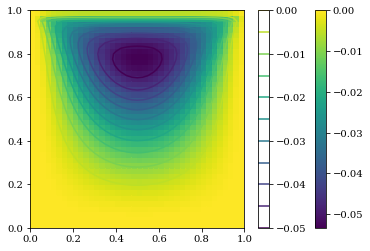

In [16]:
data = full_matrice
x = numpy.linspace(0, 1, nx)
y = numpy.linspace(0, 1, nx)
X,Y = numpy.meshgrid(x, y)
Z = data
fig, ax = pyplot.subplots()
p = ax.pcolor(Y, X, Z)
cb = fig.colorbar(p)
surf=pyplot.contour(Y,X,Z,10,cmap=cm.viridis)
fig.colorbar(surf)


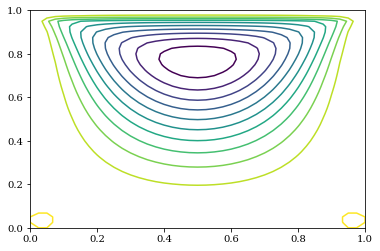

In [17]:
surf=pyplot.contour(Y,X,Z,10,cmap=cm.viridis)
fig.colorbar(surf)


0.025